In [225]:
from typing import Optional
import math
from collections import OrderedDict

import matplotlib
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from einops import rearrange, einsum

torch.manual_seed(1234)

### Sinusoidal Positional Encodings

This is used to inject some positional information into the embeddings of the token sequence. Since we compute the next token for every single token in parallel, we want some info about the position of a token within a sequence to be represented as well.
1. Unique encoding for each position (across all sequences)
2. Generalize to longer sequence than seen in training
3. Generated deterministically (so the model can learn it)
4. Linear relation between 2 encoded positions (again to help the model learn relationships)


Given a position $pos$ output a vector $d_{model}$ such that for each location $i$ in the vector the output is $$PE_{pos,2i} = \sin(pos/10000^{2i/d_{model}})$$ $$PE_{pos,2i+1} = \cos(pos/10000^{2i/d_{model}})$$
for even and odd indices respectively

we refactor as $$PE_{pos,2i} = \sin(pos.w)$$ $$PE_{pos,2i+1} = \cos(pos.w)$$ where $w=1/(10000^{2i/d_{model}}) for 0 <= 2i <= d_{model}$

![Sinusoidal PE visualization](fleetwood_sinusoidal.png "https://fleetwood.dev/posts/you-could-have-designed-SOTA-positional-encoding")
Look at the functions. For a dimension $i$ the $sin/cos$ function's wave starts out extremely quickly changing values for small $i$, and slows down a lot up to a wavelength of $10000*2\pi$.

#### Derivation to use tensor ops
$$\frac{1}{10000^{k/d_{model}}} = 10000^{-k/d_{model}} = \exp(\log(10000^{-k/d_{model}}))$$
$$ = \exp(-k/d_{model} * \log(10000))$$
this is basically
$$torch.exp(k * (-\frac{1}{d_{model}}) * \log(10000))$$

In [ ]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000) -> None:
        """Construct the entire positional encoding."""
        super().__init__()
        w = torch.exp(torch.arange(0, d_model, 2) * ((-1/d_model) * math.log(10000)))
        PE = torch.zeros([max_len, d_model])
        positions = torch.arange(0, max_len)
        # We have 2 vectors
        assert (positions.shape == (max_len,))
        assert (w.shape == (d_model // 2,))
        # If we reshape positions into a row of columns [[0], [1], [2], ...] then 
        # positions @ w -> gives us a matrix of shape [max_len, d_model/2 ]
        positions = rearrange(positions, "(len column) -> len column", column=1)
        PE[:, 0::2] = torch.sin(positions * w)
        PE[:, 1::2] = torch.cos(positions * w)
        self.register_buffer("PE", PE) # this is not to be a learnable parameter
        # However we do want it to be moved along with model.to(device) 
    
    def forward(self, x):
        _, L, D = x.shape
        x += self.PE[:L, :D]
        return x

In [241]:
class ClaudeSinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000) -> None:
        """Construct the sinusoidal positional encoding."""
        super().__init__()
        
        # Create position indices
        position = torch.arange(0, max_len).unsqueeze(1)
        # Create division term with proper shape
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        # Initialize positional encoding matrix
        PE = torch.zeros(max_len, d_model)
        
        # Apply sin to even indices
        PE[:, 0::2] = torch.sin(position * div_term)
        # Apply cos to odd indices
        PE[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer (not a parameter)
        self.register_buffer("PE", PE)
    
    def forward(self, x):
        """
        Add positional encoding to input tensor.
        
        Args:
            x: Input tensor of shape [batch_size, seq_len, d_model]
        
        Returns:
            Output tensor with positional encoding added
        """
        # Get sequence length and dimension from input
        batch_size, seq_len, d_model = x.shape
        
        # Add positional encoding to input
        x = x + self.PE[:seq_len, :d_model]
        return x

Just a reference implementation with for-loops to demonstrate speedup of torch ops.

In [235]:
# output pe -> [d_model]
def sinusoidal_position_encoding(pos: int, d_model: int = 512) -> torch.Tensor:
    # w = 1/10000**(2i/d_model)
    w = torch.tensor([1/(10_000**(k/d_model)) for k in range(0, d_model, 2)])
    x_indices = pos * w 
    PE_even = torch.sin(x_indices)
    PE_odd = torch.cos(x_indices)
    PE_even = rearrange(PE_even, "(new_dim l) -> l new_dim", new_dim=1)
    PE_odd = rearrange(PE_odd, "(new_dim l) -> l new_dim", new_dim=1)
    interleaved_result = rearrange([PE_even, PE_odd], "function d_model element -> (d_model element function)")
    assert (interleaved_result.shape == (d_model,))
    return interleaved_result

def generate_position_encoding(max_len: int = 5000, d_model: int = 512) -> torch.Tensor:
    all_positions_encoding = torch.zeros([max_len, d_model], dtype=torch.float32)
    for position in range(max_len):
        all_positions_encoding[position, :] += sinusoidal_position_encoding(position, d_model)
    return all_positions_encoding

In [236]:
def positionalencoding1d(d_model, length):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    if d_model % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dim (got dim={:d})".format(d_model))
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe

#### Note below the speed differential of the vectorized pytorch ops. Eye the units 👀

In [237]:
%%timeit
generate_position_encoding()

284 ms ± 3.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [238]:
%%timeit
SinusoidalPositionalEncoding(512)

3.74 ms ± 104 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [239]:
print(SinusoidalPositionalEncoding(d_model=512).PE.shape)

torch.Size([5000, 512])


In [243]:
def test_sinusoidal_positional_encoding_class():
    max_len = 500
    d_model = 512
    pe_class = SinusoidalPositionalEncoding(d_model=d_model, max_len=max_len)
    cpe = ClaudeSinusoidalPositionalEncoding(d_model=d_model, max_len=max_len)

    print(torch.allclose(cpe(torch.zeros([1, max_len, d_model])), pe_class(torch.zeros([1, max_len, d_model]))))
    
    print(torch.allclose(positionalencoding1d(d_model=d_model, length=max_len).unsqueeze(0), pe_class(torch.zeros([1, max_len, d_model]))))
    print(pe_class(torch.zeros([1, max_len, d_model])) == generate_position_encoding(max_len=max_len, d_model=d_model).unsqueeze(0))
    assert(torch.allclose(pe_class(torch.zeros([1, max_len, d_model])), generate_position_encoding(max_len=max_len, d_model=d_model).unsqueeze(0)))

test_sinusoidal_positional_encoding_class()

True
True
tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True, False,  True],
         [ True,  True,  True,  ...,  True, False,  True],
         ...,
         [ True,  True,  True,  ...,  True, False,  True],
         [ True,  True,  True,  ...,  True, False,  True],
         [ True,  True,  True,  ...,  True, False,  True]]])


AssertionError: 

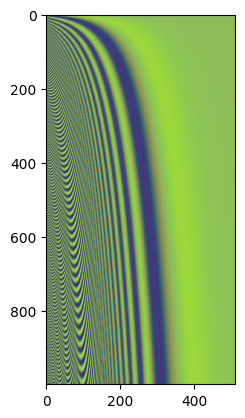

In [244]:
import matplotlib.pyplot


matplotlib.pyplot.imshow((SinusoidalPositionalEncoding(d_model=512, max_len=1000).PE).numpy())

matplotlib.pyplot.show()

#### Function that calculates attention (single-headed for now).

#### A Decoder-Only Transformer Language Model

For now we are implementing it with single headed attention

In [245]:
"""
Dimension key:
L: sequence length
D: model dimension (d_model)
V: vocabulary size
F: feed-forward subnetwork's hidden size
K: size of each attention key or value (d_k,d_v,d_kv)
"""

"\nDimension key:\nL: sequence length\nD: model dimension (d_model)\nV: vocabulary size\nF: feed-forward subnetwork's hidden size\nK: size of each attention key or value (d_k,d_v,d_kv)\n"

In [89]:
class EmbeddingLayer(nn.Module):
    def __init__(self, vector_size: int, vocab_size: int):
        super().__init__()
        self.d_model = vector_size
        self.scaling_factor = math.sqrt(self.d_model) # a detail in the paper
        self.lut = nn.Embedding(vocab_size, vector_size)
    
    def forward(self, input_indices: torch.Tensor):
        return self.lut(input_indices) * self.scaling_factor

    def get_weights(self):
        return self.lut.weight

In [199]:
class FeedForward(nn.Module):
    def __init__(self, D: int, H: int = 2048):
        super().__init__()
        self.layers = nn.Sequential(OrderedDict([
            ("linear1", nn.Linear(D, H)),
            ("relu1", nn.ReLU()),
            ("linear2", nn.Linear(H, D)),
        ]))
    
    def forward(self, x):
        return self.layers.forward(x)



class Decoder(nn.Module):
    def __init__(self, d_model: int, d_k: int, d_v: int, P_drop: int):
        super().__init__()
        # attention function
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.P_drop = P_drop
        self.W_query_DK = nn.Parameter(torch.randn([self.d_model, self.d_k]), requires_grad=True)
        self.W_key_DK = nn.Parameter(torch.randn([self.d_model, self.d_k]), requires_grad=True)
        self.W_value_DK = nn.Parameter(torch.randn([self.d_model, self.d_v]), requires_grad=True)
        nn.init.kaiming_uniform_(self.W_query_DK)
        nn.init.kaiming_uniform_(self.W_key_DK)
        nn.init.kaiming_uniform_(self.W_value_DK)

        # normalize over the last dimension in shape [N, d_v], so each layer
        self.dropout1 = nn.Dropout(p=self.P_drop)
        self.layernorm1 = nn.LayerNorm(self.d_v)
        self.feedforward = FeedForward(D=self.d_model)
        self.dropout2 = nn.Dropout(p=self.P_drop)
        self.layernorm2 = nn.LayerNorm(self.d_model)
    
    def forward(self, input_BLD: torch.Tensor) -> torch.Tensor:
        assert(input_BLD.dim() == 3 and input_BLD.shape[-1] == self.d_model)
        input_token_length = input_BLD.shape[1]

        Query_BLK = torch.matmul(input_BLD, self.W_query_DK)
        Key_BLK = torch.matmul(input_BLD, self.W_key_DK)
        Value_BLK = torch.matmul(input_BLD, self.W_value_DK)

        # attn_values_BLV = self.scaled_dot_prd_attention(Query_BLK, Key_BLK, Value_BLK, visualize_attn=False)
        built_in_attn = F.scaled_dot_product_attention(Query_BLK.unsqueeze(1), Key_BLK.unsqueeze(1), Value_BLK.unsqueeze(1), is_causal=True)
        attn_values_BLV = rearrange(built_in_attn, "B H L V -> (B H) L V")

        # print(attn_values_BLV.unsqueeze(1)[0, :, :10, :10] == built_in_attn[0, :, :10, :10])
        # assert(torch.allclose(attn_values_BLV, built_in_attn.unsqueeze(1)))

        reg_attn_values_BLV = self.dropout1(attn_values_BLV)
        normalized_attn_values_BLV = self.layernorm1(reg_attn_values_BLV + input_BLD)
        assert(normalized_attn_values_BLV.shape == attn_values_BLV.shape)
        assert(normalized_attn_values_BLV.dim() == 3 and normalized_attn_values_BLV.shape[-1] == self.d_model)

        ffn_BLD = self.feedforward(normalized_attn_values_BLV)
        reg_ffn_BLD = self.dropout1(ffn_BLD)

        normalized_ffn_BLD = self.layernorm2(reg_ffn_BLD + normalized_attn_values_BLV)
        return normalized_ffn_BLD
    
    def scaled_dot_prd_attention(self, Query_BLK, Key_BLK, Value_BLK, mask: bool = True, visualize_attn: bool = False) -> torch.Tensor:
        assert (Query_BLK.shape == Key_BLK.shape)

        Key_BKL = rearrange(Key_BLK, "B L K -> B K L")

        qk_BLL = einsum(Query_BLK, Key_BKL, "B S_Q K, B K S_K -> B S_Q S_K")
        scaled_qk_BLL = qk_BLL / math.sqrt(self.d_model)
        # since we want to average the attended keys between the dimension d_k
        if mask:
            tril_qk = torch.tril(scaled_qk_BLL)
            scaled_qk_BLL = torch.where(tril_qk == 0, float("-inf"), scaled_qk_BLL)
        if visualize_attn:
            matplotlib.pyplot.matshow(scaled_qk_BLL[0].cpu().detach().numpy())

        weighted_keys_BLL = torch.softmax(scaled_qk_BLL, dim=-1)
        attention_output_BLV = einsum(weighted_keys_BLL, Value_BLK, "B S_Q L , B L D_V -> B S_Q D_V") 
        return attention_output_BLV



In [246]:
class Transformer(nn.Module):
    def __init__(self, d_model: int = 512, num_decoders: int = 6, maximum_sequence_length: int = 5000, P_drop: float = 0.1, vocabulary_size: int = 10000):

        super().__init__()
        assert (num_decoders >= 1)
        self.d_model = d_model
        self.d_k, self.d_v = d_model, d_model

        self.positional_encodings = SinusoidalPositionalEncoding(d_model=self.d_model)

        self.emb_dropout = nn.Dropout(p = P_drop)
        self.embed = EmbeddingLayer(vector_size=self.d_model, vocab_size=vocabulary_size)
        self.decoder_stack = nn.Sequential()
        for _ in range(num_decoders):
            self.decoder_stack.append(Decoder(d_model = self.d_model, d_k = self.d_k, d_v = self.d_v, P_drop = P_drop))

        self.linear = nn.Linear(self.d_model, vocabulary_size)
        self.linear.weight = self.embed.lut.weight
        self.logsoftmax = nn.LogSoftmax(dim=-1) # this is LogSoftmax so we can get the NLLLoss
    
    def forward(self, input_tokens_BL: torch.Tensor):
        assert(input_tokens_BL.dim() == 2 and input_tokens_BL.dtype == torch.int)
        B, L = input_tokens_BL.shape
        embed_tokens_BLD = self.embed(input_tokens_BL)
        assert(embed_tokens_BLD.dim() == 3 and embed_tokens_BLD.shape == torch.Size([B, L, self.d_model]))

        embed_tokens_BLD = self.positional_encodings(embed_tokens_BLD)

        decoder_output_BLD = self.decoder_stack(embed_tokens_BLD)

        assert(decoder_output_BLD.dim() == 3 and decoder_output_BLD.shape == torch.Size([B, L, self.d_model]))
        linear_output_BLV = self.linear(decoder_output_BLD)
        next_token_probabilities_BLV = self.logsoftmax(linear_output_BLV)

        # return linear_output_BLV
        return next_token_probabilities_BLV # this is of shape [seq_len, vocab_size] (each token has computed a probabilistic next token)
        """Now we map these back to the words based on the maximum token."""


In [247]:
device = torch.device("mps")

In [248]:
%matplotlib inline
def test_transformer_runs():
    """With a dummy input lets just test if the components of the transformer fit together"""
    input_ints = torch.tensor([1, 2, 3, 4, 3, 6, 5, 7, 8], dtype=torch.int).to(device)
    batched_input = torch.stack((input_ints, input_ints))
    model = Transformer(d_model=8).to(device)
    print(model.forward(batched_input).shape)

test_transformer_runs()

torch.Size([2, 9, 10000])


Dataset sample generation

In [249]:
import random

def create_reversed_training_sample(vocab_size: int, max_sequence_length):
    """Generate a palindromic tensor of token indices.
    Returns: [A,Rev(A)]
    """
    random_sample_L = torch.randint(1, vocab_size-1, (max_sequence_length,), dtype=torch.int)
    return torch.cat((random_sample_L, torch.flip(random_sample_L, dims=(0,))))

def test_training_sample_generation():
    test_vocab_size=1000
    sample_length = 40
    gen_sample_L = create_reversed_training_sample(test_vocab_size, sample_length//2)
    assert gen_sample_L.shape == torch.Size([sample_length])
    orig_L, rev_L = torch.tensor_split(gen_sample_L, 2, dim=0)
    assert torch.allclose(orig_L, torch.flip(rev_L, dims=(0,)))

test_training_sample_generation()

In [250]:
def create_training_sample(vocab_size: int, max_sequence_length):
    """Generate a random tensor of token indices.
    """
    random_sample_L = torch.randint(1, vocab_size-1, (max_sequence_length,), dtype=torch.int)
    return random_sample_L

In [251]:

def shift_decoder_input_right(sample_BL: torch.Tensor) -> torch.Tensor:
    st_B = torch.zeros([sample_BL.shape[0], 1]).to(sample_BL.get_device(), dtype=torch.int32)
    return torch.cat([st_B, sample_BL], dim=1)

def pad_input_right(sample_BL: torch.Tensor) -> torch.Tensor:
    ed_B = torch.zeros([sample_BL.shape[0], 1]).to(sample_BL.get_device(), dtype=torch.int32)
    return torch.cat([sample_BL, ed_B], dim=1)

In [252]:
def train_loop(train_dataloader, model: torch.nn.Module, loss_fn, optimizer, device, epochs, train_dataset_len: int, scheduler: torch.optim.lr_scheduler, sequence_length: int,
                val_dataloader, test_dataset_len: int):
    record_train_loss = []
    record_train_accuracy = []
    record_test_loss = []
    record_test_accuracy = []
    for ep in range(epochs):
        train_loss, train_accuracy, test_loss, test_accuracy = 0, 0, 0, 0

        model.train()
        for idx, batch in enumerate(train_dataloader):
            batch_BL = batch.to(device)

            optimizer.zero_grad()
            # No shifting
            next_token_prob_BLV = model(batch_BL)
            flipped_BL = batch_BL.flip(dims=(1,))

            next_token_prob_BVL = rearrange(next_token_prob_BLV, "B L V -> B V L")
            # mask the first half

            loss = loss_fn(next_token_prob_BVL, flipped_BL.to(torch.long))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_accuracy += (next_token_prob_BLV.argmax(-1) == flipped_BL).sum().item()
        scheduler.step()
        record_train_loss.append(train_loss/train_dataset_len)
        record_train_accuracy.append(train_accuracy / (train_dataset_len*sequence_length))
        
        model.eval()
        for idx, batch in enumerate(val_dataloader):
            batch_BL = batch.to(device)
            # No shifting
            next_token_prob_BLV = model(batch_BL)
            flipped_BL = batch_BL.flip(dims=(1,))
            next_token_prob_BVL = rearrange(next_token_prob_BLV, "B L V -> B V L")

            loss = loss_fn(next_token_prob_BVL, flipped_BL.to(torch.long))

            test_loss += loss.item()
            test_accuracy+= (next_token_prob_BLV.argmax(-1) == flipped_BL).sum().item()
        record_test_loss.append(train_loss / test_dataset_len)
        record_test_accuracy.append(test_accuracy / (test_dataset_len * sequence_length))

        if ep % 5 == 0:
            print(f"Epoch {ep}:")
            print(f"Loss = {record_train_loss[ep]} Accuracy = {record_train_accuracy[ep]}")
            print(f"Val Loss = {record_test_loss[ep]} Val Accuracy = {record_test_accuracy[ep]}")

    
    return record_train_loss, record_train_accuracy, record_test_loss, record_test_accuracy



In [253]:
def test_loop(dataloader, model: torch.nn.Module, loss_fn, device):
    size = len(dataloader)
    print(f"Test set samples: {size}")
    model.eval()
    test_loss, correct = 0, 0
    total_tokens = 0
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            total_tokens += batch.numel()
            batch_BL = batch.to(device)
            # start_input_BL = shift_decoder_input_right(batch_BL)
            # padded_input_BL = pad_input_right(start_input_BL)
            # next_token_prob_BLV = model(padded_input_BL)
            # No shifting
            next_token_prob_BLV = model(batch_BL)
            padded_input_BL = batch_BL

            first_half_seq_len = padded_input_BL.shape[1]

            next_token_prob_BVL = next_token_prob_BLV.transpose(1, 2)
            masked_input_BL = padded_input_BL.to(torch.long) # dtype expected by nll_loss
            masked_input_BL[..., 0:first_half_seq_len//2] = -100

            test_loss += loss_fn(next_token_prob_BVL, masked_input_BL).item()
            correct += (next_token_prob_BLV.argmax(dim=-1) == padded_input_BL).sum().item()
    
    test_loss /= total_tokens
    correct /= total_tokens
    print(f"Test error: Accuracy: {100*correct}, Avg loss: {test_loss}\n")

### Train loop

In [254]:
vocab_size = 16
max_sequence_length = 8
dataset_size = 100_000
batch_size = 32
dataset = [create_training_sample(vocab_size, max_sequence_length) for _ in range(int(dataset_size))]
# dataset = [torch.tensor([2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int) for _ in range(int(dataset_size))]
train_dataset = dataset[:int(dataset_size * .7)]
val_dataset = dataset[int(dataset_size * .7):]
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [255]:
model = Transformer(num_decoders=2, d_model=64, maximum_sequence_length=max_sequence_length, vocabulary_size=vocab_size, P_drop=0.3).to(device)

In [257]:

epochs = 5

loss = F.nll_loss
adam_opt = torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09, lr=0.01) # parameters from paper. No LR schedule, default 0.001
scheduler = torch.optim.lr_scheduler.LinearLR(adam_opt)
losses = train_loop(
    train_dataloader=train_dataloader,
    model=model,
    loss_fn=loss,
    optimizer=adam_opt,
    scheduler=scheduler,
    device=device,
    epochs=epochs,
    train_dataset_len=len(train_dataset),
    sequence_length=max_sequence_length,
    val_dataloader=val_dataloader,
    test_dataset_len=len(val_dataset)
)


Epoch 0:
Loss = 0.08027722754137856 Accuracy = 0.15039464285714285
Val Loss = 0.18731353092988332 Val Accuracy = 0.15758333333333333


In [258]:
test_op = model(train_dataset[0].unsqueeze(0).to(device))
print(test_op)
print(train_dataset[0].unsqueeze(0))
print(test_op.argmax(-1))

tensor([[[-30.2801,  -2.7348,  -2.6437,  -2.8932,  -2.6621,  -2.7061,  -2.8068,
           -2.6791,  -2.7053,  -2.6857,  -2.5854,  -2.7790,  -2.5323,  -1.9718,
           -2.9602, -31.0640],
         [-31.7511,  -3.1802,  -2.7103,  -2.7543,  -2.7084,  -3.2864,  -2.3441,
           -2.5672,  -3.1916,  -2.8278,  -2.7075,  -2.8993,  -2.5672,  -1.5642,
           -3.1348, -32.4715],
         [-31.7586,  -3.1812,  -2.7117,  -2.7551,  -2.7087,  -3.2883,  -2.3456,
           -2.5670,  -3.1931,  -2.8293,  -2.7070,  -2.9004,  -2.5669,  -1.5615,
           -3.1345, -32.4800],
         [-31.7686,  -3.1851,  -2.7141,  -2.7567,  -2.7098,  -3.2913,  -2.3493,
           -2.5672,  -3.1966,  -2.8326,  -2.7065,  -2.9034,  -2.5661,  -1.5550,
           -3.1346, -32.4909],
         [-31.7717,  -3.1854,  -2.7144,  -2.7568,  -2.7098,  -3.2922,  -2.3497,
           -2.5668,  -3.1971,  -2.8332,  -2.7061,  -2.9036,  -2.5665,  -1.5543,
           -3.1343, -32.4944],
         [-31.7760,  -3.1868,  -2.7154,  -2.7

Accuracy should be 50% ish since the model should only know the second half of the tokens.

In [259]:

test_loop(val_dataloader, model, loss, device)

Test set samples: 938
Test error: Accuracy: 19.79375, Avg loss: 0.010850921192765236



In [260]:
def inference(model, sample, device: torch.device):
    model.eval()
    print(f"Sample {sample}\n")
    input_BL = sample.to(device)
    result_BL = []
    with torch.no_grad():
        total_tokens = sample.numel()
        print(f"Total Sample length {total_tokens}\n")

        
        start_input_BL = shift_decoder_input_right(input_BL)
        padded_input_BL = pad_input_right(start_input_BL)
        seq_next_token_probabilities_BLV = model(padded_input_BL)

        result_BL = seq_next_token_probabilities_BLV.argmax(dim=-1)

    print(result_BL == padded_input_BL.flip(dims=(-1,)))
    print(result_BL)
    return result_BL

random_sample_L = create_training_sample(vocab_size, max_sequence_length)
# random_sample_L = train_dataset[1]
random_sample_BL = rearrange(random_sample_L, "(B L) -> B L", B = 1)
print(random_sample_BL.shape)
print(random_sample_BL)
# print(random_sample[:2])
result = torch.tensor(inference(model, random_sample_BL, device))
        



torch.Size([1, 8])
tensor([[ 3,  9, 10, 12, 12,  9, 14,  5]], dtype=torch.int32)
Sample tensor([[ 3,  9, 10, 12, 12,  9, 14,  5]], dtype=torch.int32)

Total Sample length 8

tensor([[False, False, False, False, False, False, False, False, False, False]],
       device='mps:0')
tensor([[8, 8, 6, 6, 2, 2, 6, 6, 5, 5]], device='mps:0')


/var/folders/bs/5fk1gpqj5qs67jr4myg5dbth0000gn/T/ipykernel_97248/3216946939.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(inference(model, random_sample_BL, device))
